# Эффективность регистрации и рад.поправки

Необходимо определить эффективность регистрации от энергии рад.фотона и с её помощью вычислить рад.поправки

In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import os.path
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylib.style as pys
import pylib.preprocess as preprocess
import pylib.fit as pyfit
import pylib.regeff as pyreg
import iminuit
from glob import glob

%matplotlib inline
plt.rcParams['figure.dpi'] = 120

In [19]:
SEASON = '17'
FIT_RANGE = (-40, 20)

In [20]:
mc_tree = uproot.open(f'../trees/{SEASON}/uniform.root')['t']

In [21]:
df_mc = preprocess.read_tree(mc_tree, mc=True)

In [22]:
df_mc = df_mc.query(f'x1>{FIT_RANGE[0]}&x1<{FIT_RANGE[1]}')

In [23]:
several_points = df_mc.groupby('ebeam').agg({'runnum' : 'nunique'}).query('runnum>1')
several_points

runnum
ebeam        
937.5       2
940.2       2

**Удаляю одинаковые точки, не из-за того, что плохие, а из-за неумения нормально с ними работать пока**

In [24]:
df_mc = df_mc.drop(several_points.index, axis=0)

In [25]:
reg = pyreg.RegEff(df_mc, f'/spoolA/petrov/refac20/data/{SEASON}/trees_uniform.txt')

100% (35 of 35) |########################| Elapsed Time: 0:00:08 Time:  0:00:08


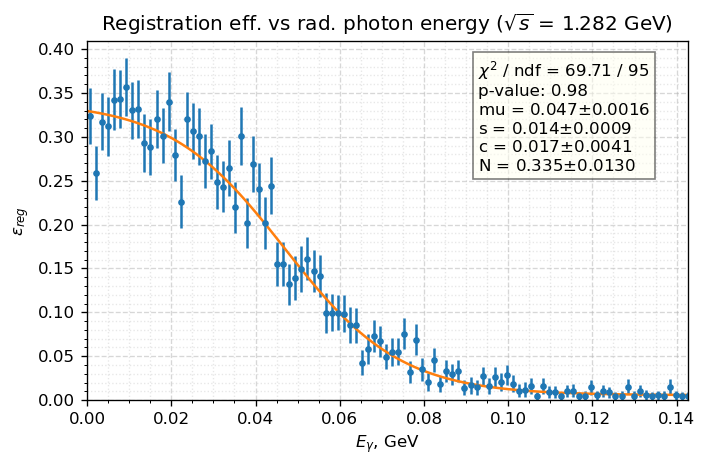

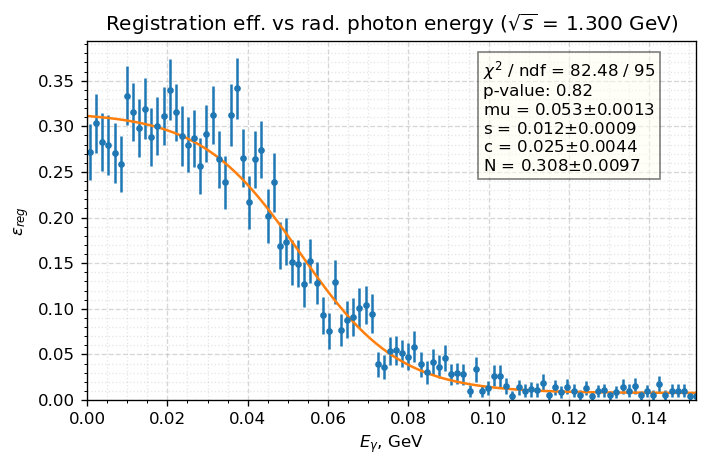

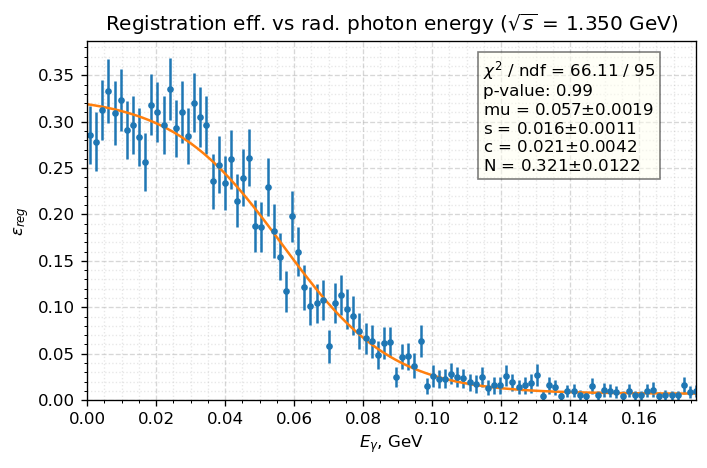

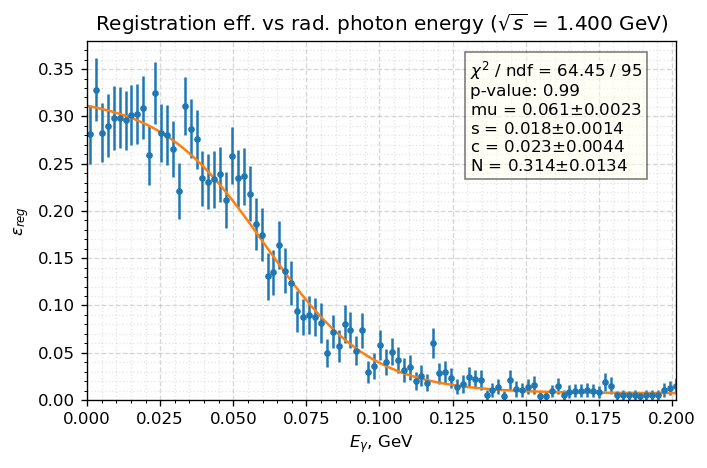

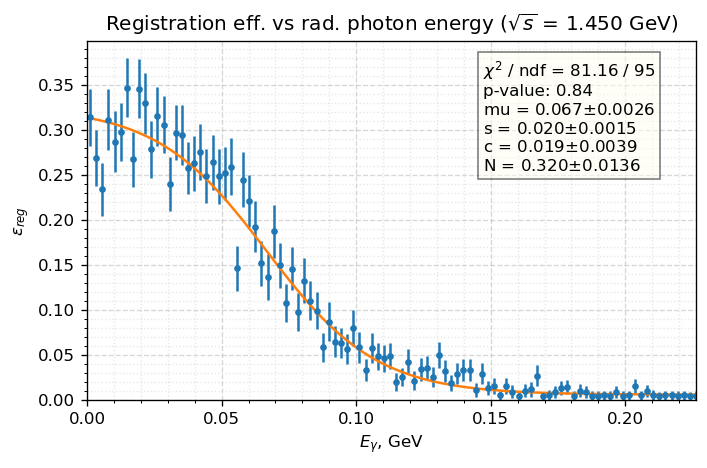

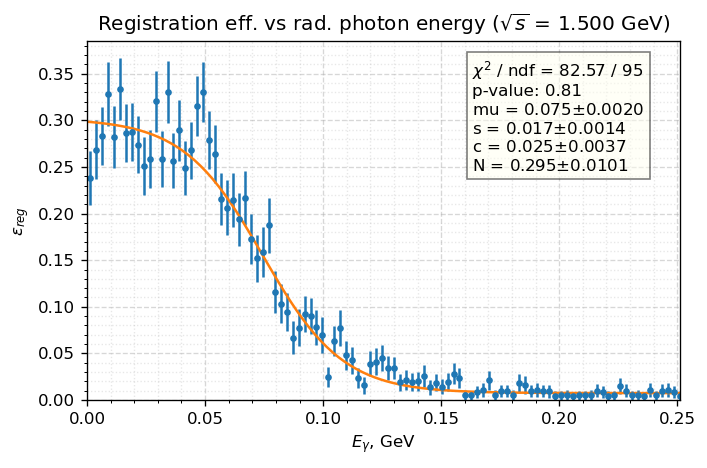

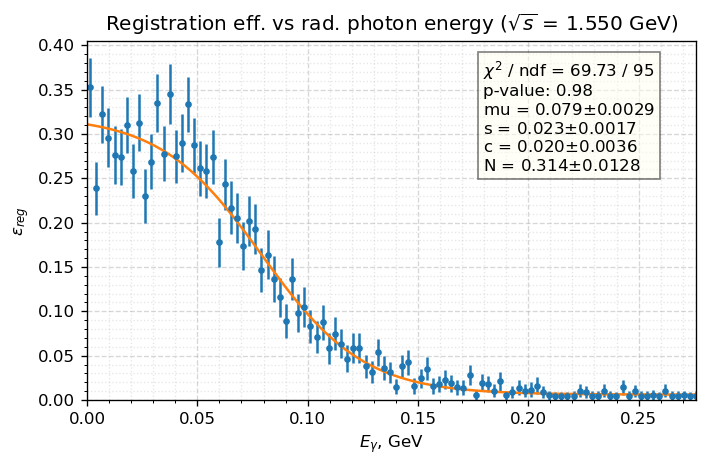

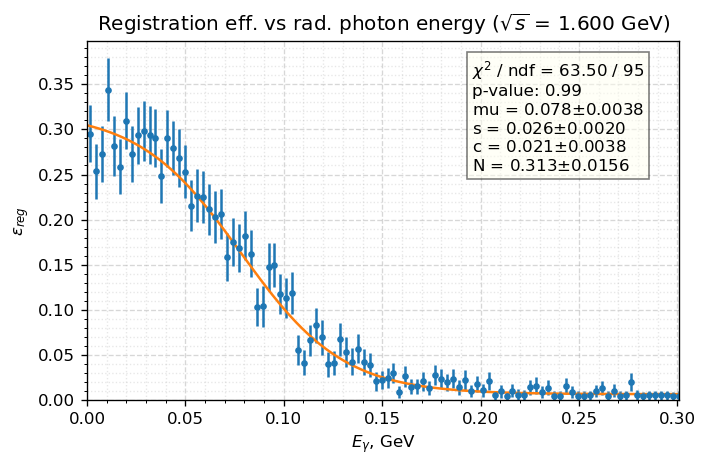

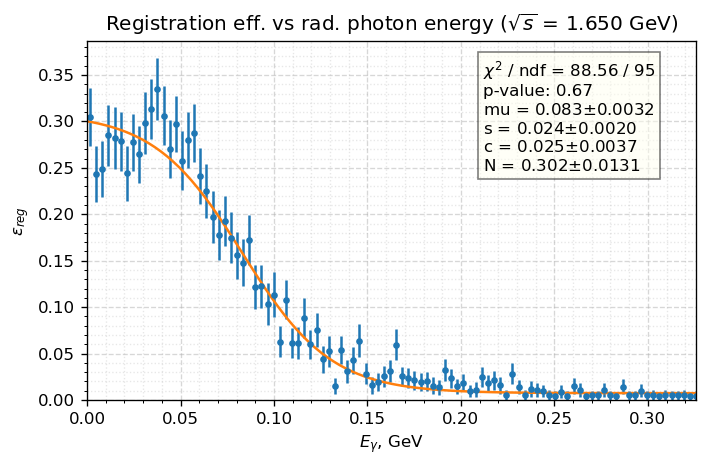

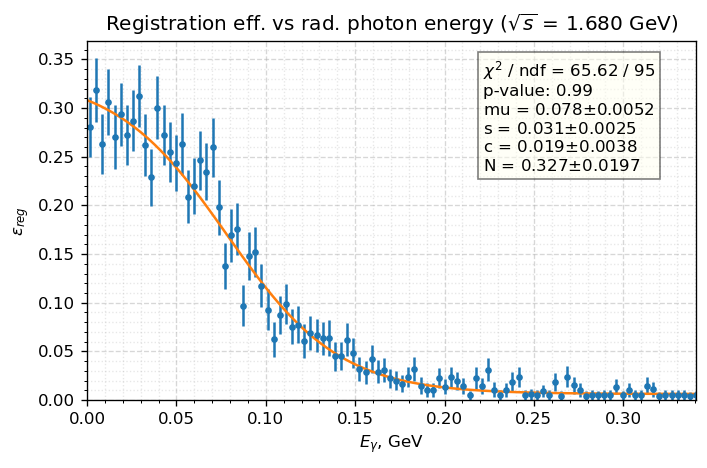

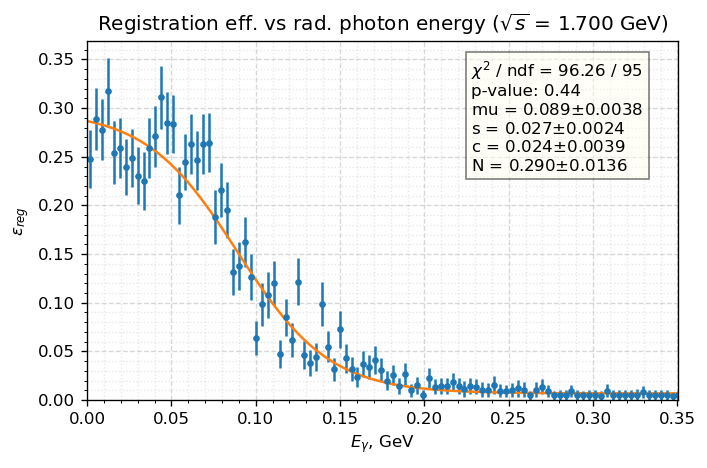

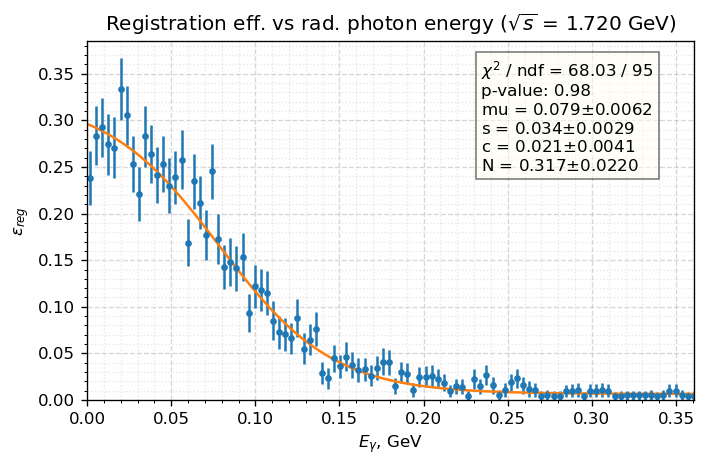

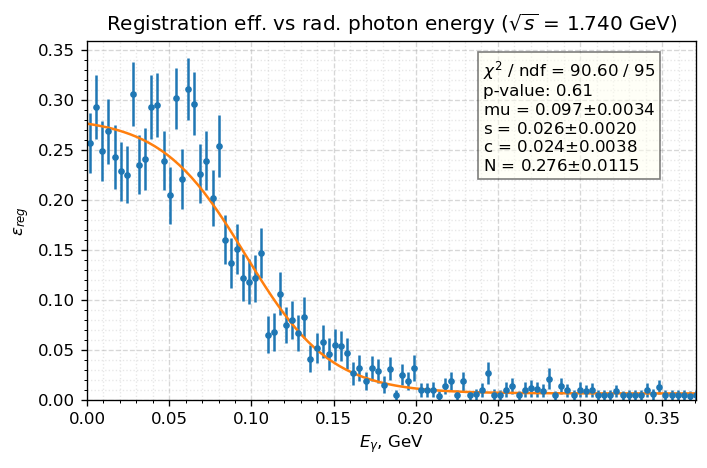

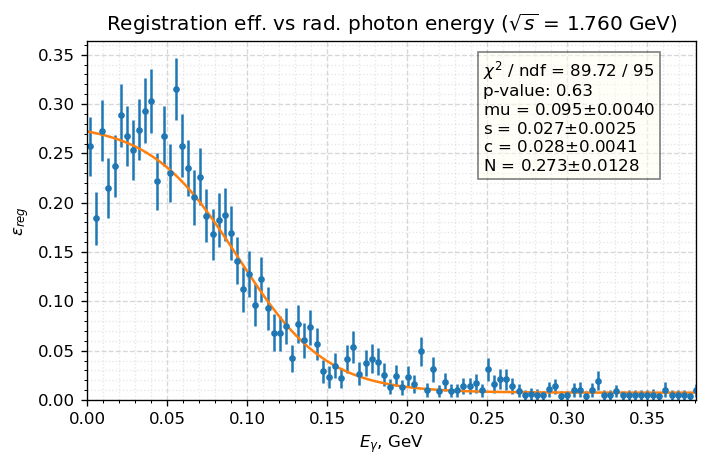

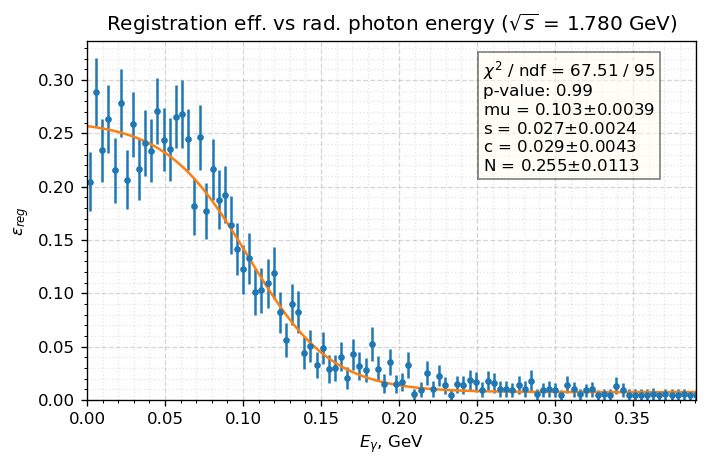

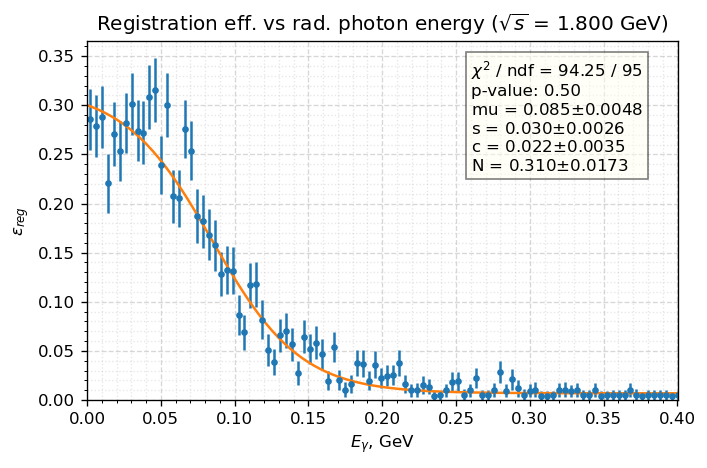

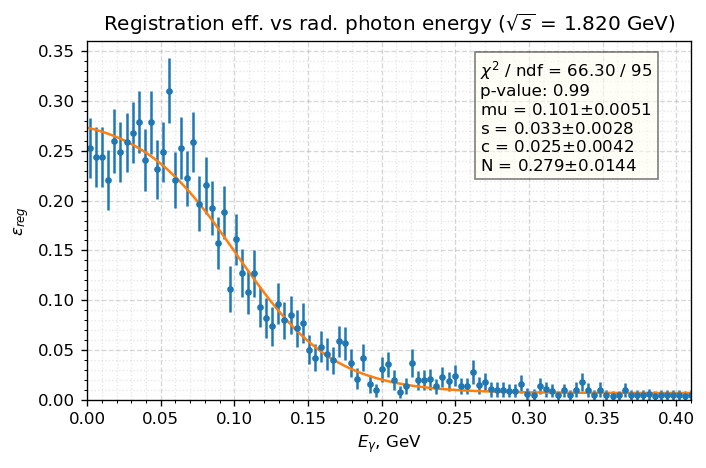

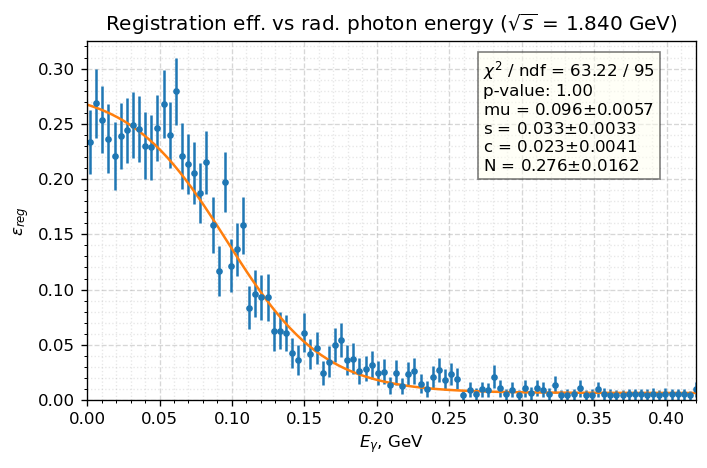

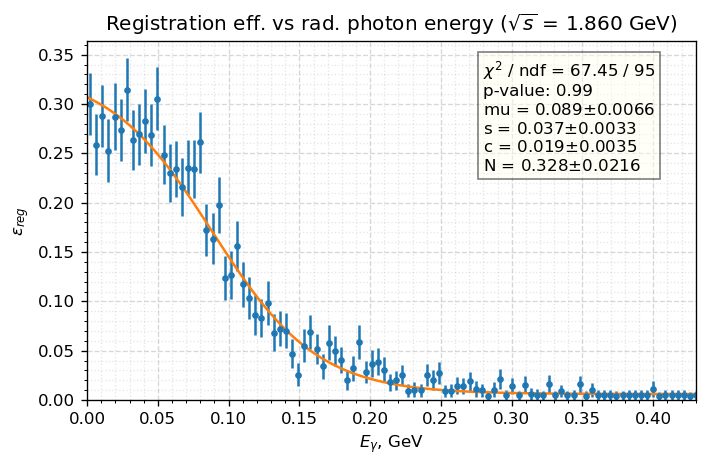

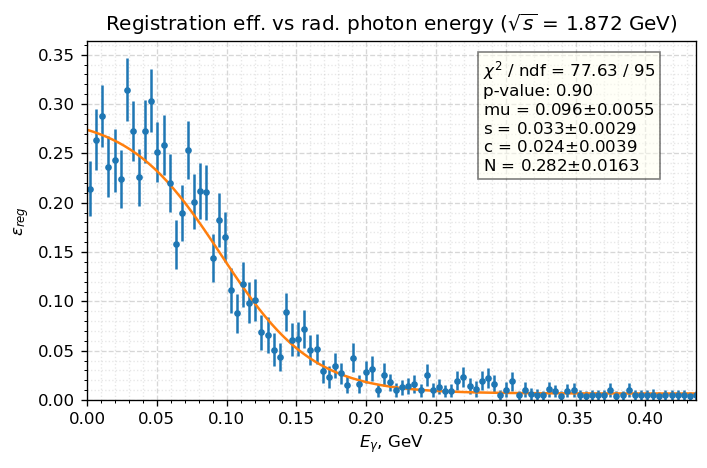

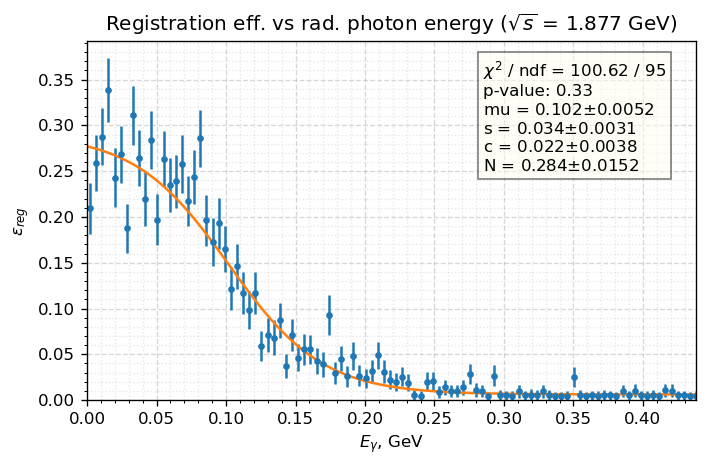

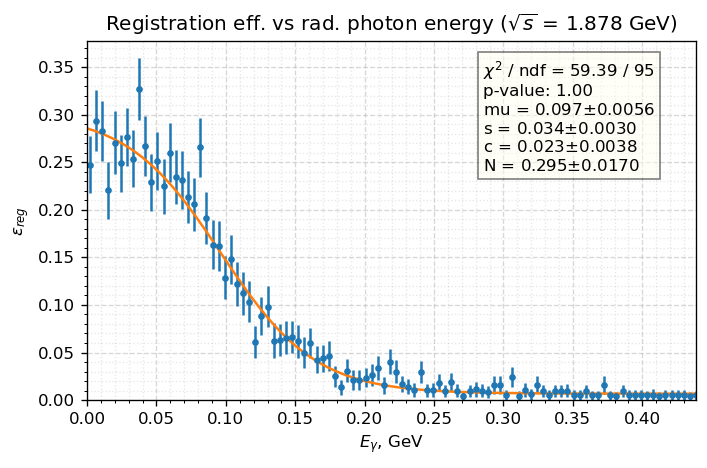

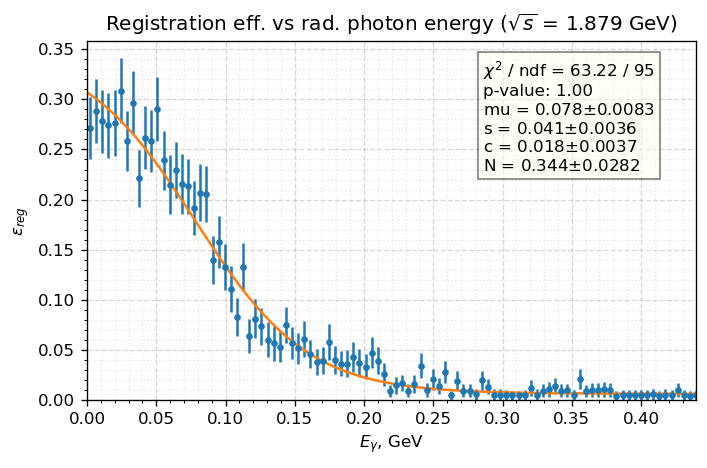

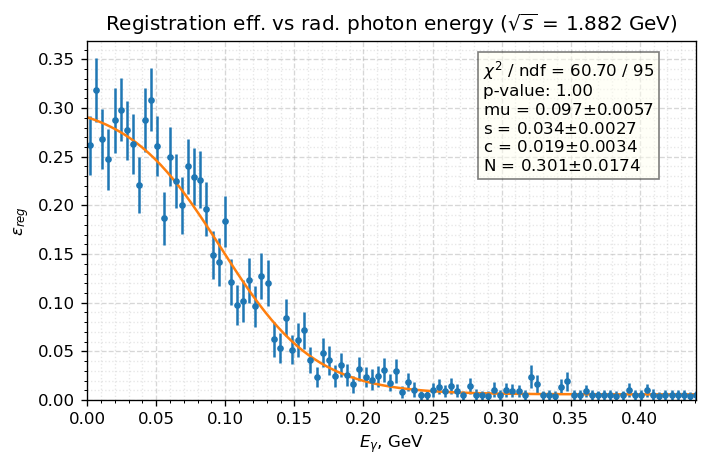

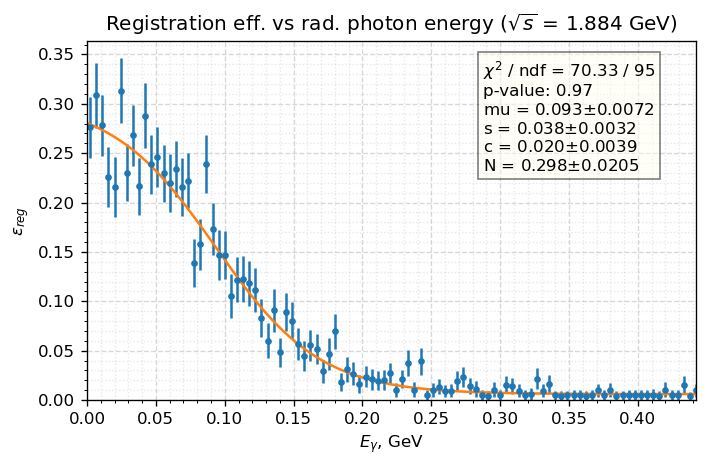

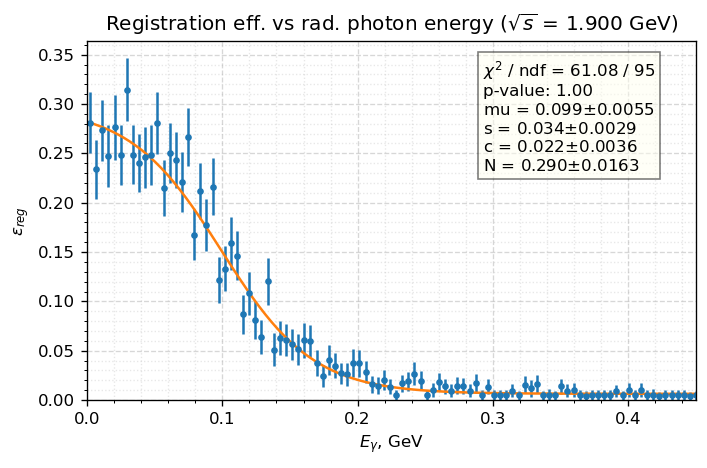

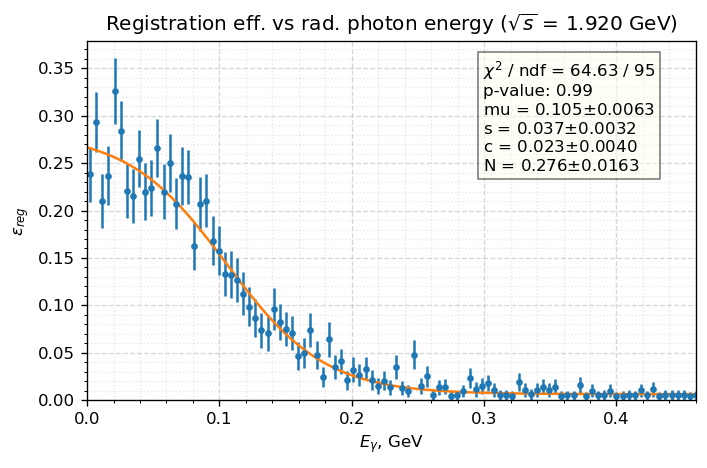

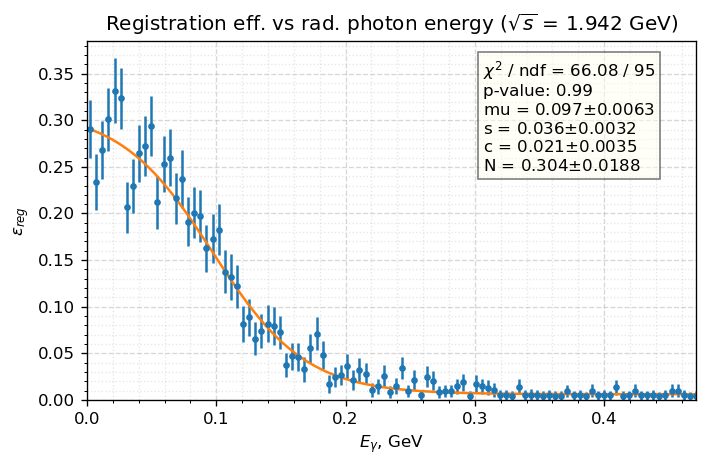

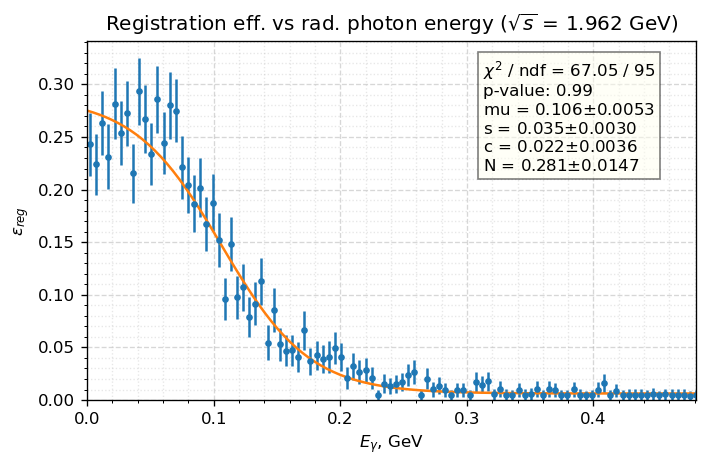

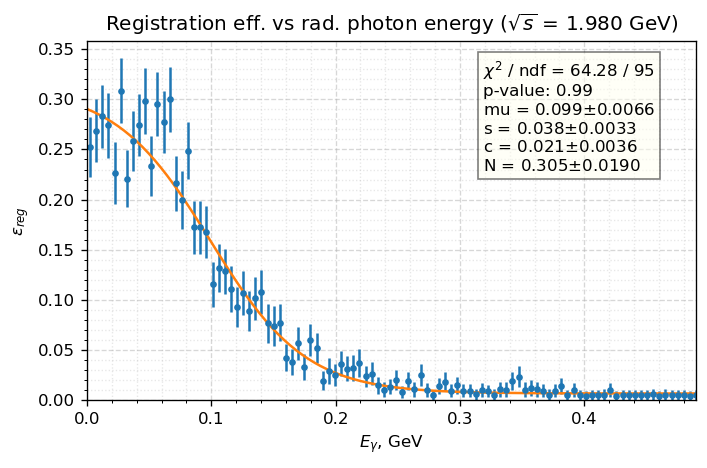

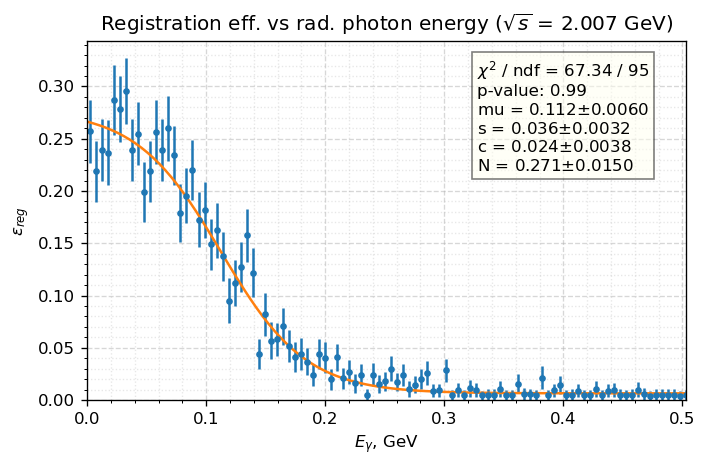

In [26]:
for i in range(len(reg)):
    reg.fit(i)
    if not(os.path.isdir(f'images/regeff{SEASON}')):
        os.mkdir(f'images/regeff{SEASON}')
    plt.savefig(f'images/regeff{SEASON}/{i}.png')
    plt.show()

In [12]:
# reg.fit_results.to_csv(f'../data/{SEASON}/results/reg_eff.csv')

In [13]:
reg.fit_results.head()

mu         s         c         N    mu_err     s_err     c_err  \
641.0  0.046934  0.013754  0.016560  0.334650  0.001645  0.000938  0.004099   
650.0  0.052971  0.012316  0.025321  0.307587  0.001306  0.000855  0.004430   
675.0  0.056630  0.015992  0.021272  0.321037  0.001899  0.001107  0.004234   
700.0  0.060810  0.018043  0.023068  0.314240  0.002340  0.001386  0.004403   
725.0  0.066673  0.020474  0.018751  0.319829  0.002625  0.001505  0.003861   

          N_err      eff0  eff0_err  
641.0  0.013007  0.329513  0.013036  
650.0  0.009680  0.311261  0.010377  
675.0  0.012219  0.318824  0.012405  
700.0  0.013376  0.311044  0.013346  
725.0  0.013600  0.313961  0.013343

In [6]:
import re

In [14]:
dfs_reg = {re.findall(r'data/(.*)/results', i)[0] : 
           pd.read_csv(i, index_col=0) for i in glob('../data/*/results/reg_eff.csv')}

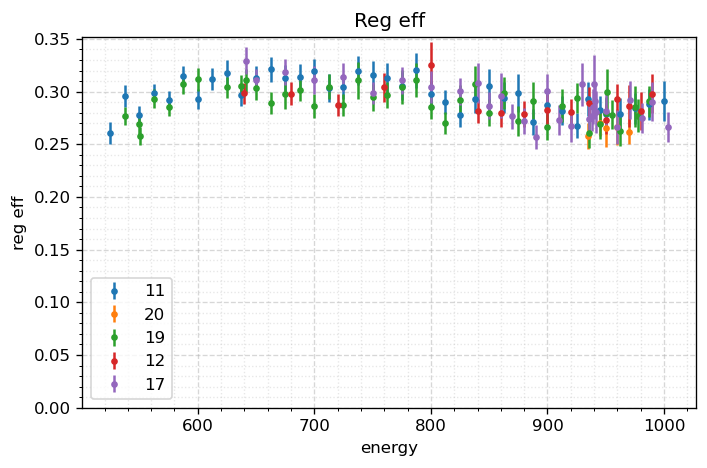

In [16]:
for key in dfs_reg:
    plt.errorbar(dfs_reg[key].index, dfs_reg[key].eff0, 
                 yerr=dfs_reg[key].eff0_err, fmt='.', label=key)
# plt.errorbar(dd.index, dd.eff0, yerr=dd.eff0_err, fmt='.')
pys.my_style('Reg eff', xtitle='energy', ytitle='reg eff', legend=True,
            ylim=(0, None))

## Аппроксимация сечения

In [37]:
from pylib.csapprox import MDVM

In [97]:
df_koz = pd.read_csv('images/kozyrev.txt').rename({'E': 'emeas', 'cs': 'cs_born',
                                                  'cs_err': 'cs_born_err'}, axis=1)
df_koz['emeas'] /= 2

In [98]:
dfs = [pd.read_csv('images/res11_new.csv', index_col=0),
       pd.read_csv('images/res12_new.csv', index_col=0),
       pd.read_csv('images/res19_new.csv', index_col=0),
       pd.read_csv('images/res20_new.csv', index_col=0),
      ]

In [99]:
for df in dfs:
    if 'n_sig_exp' not in df.columns:
        df['n_sig'] = df['n_exp']*df['f_exp']
        df['n_sig_err'] = df['n_sig']*np.sqrt( (df['n_exp_err']/df['n_exp'])**2 + (df['f_exp_err']/df['f_exp'])**2 )
    else:
        df['n_sig'] = df['n_sig_exp']
        df['n_sig_err'] = df['n_sig_exp_err']
    df['cs_born_err'] = df['cs_born']*np.sqrt( (df['n_sig_err']/df['n_sig'])**2 + (df['eff_reg_err']/df['eff_reg'])**2 +\
                                             (df['eff_trig_err']/df['eff_trig'])**2)

In [100]:
dfs = pd.concat([df_koz, *dfs])[['emeas', 'cs_born', 'cs_born_err']]
dfs.emeas *=2e-3

In [113]:
mdvm = MDVM()

In [114]:
params = [0.9639, 1.0919, -0.0062, -0.0279, 1.0509, 
          -0.0674, 1740.0, 250.0, 1670.0, 315.0, 1680.0, 
          150.0, 2150.0, 315.0, 1470.0, 400.0, 1425.0, 
          225.0, 2239.0, 139.0, 1.3856, 0.0064, -0.2363, 0.01]

In [115]:
m = iminuit.Minuit(iminuit.cost.LeastSquares(dfs.emeas, 
        dfs.cs_born, dfs.cs_born_err, lambda x, a0, a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, a11, a12, a13, a14, a15, a16, a17, a18, a19, a20, a21, a22, a23: 
            mdvm.Cross_Section_Neutral(x, [a0, a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, a11, a12, a13, a14, a15, a16, a17, a18, a19, a20, a21, a22, a23])), *params)

In [116]:
m.simplex()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 495.3                      │             Nfcn = 3335              │
│ EDM = 0.102 (Goal: 0.1)          │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│INVALID Minimum│ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ ABOVE EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│ NO Covariance │     Hesse ok     │APPROXIMATE│NOT pos. def.│ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a0   │  0.9048   │  0.0016   │            │            │         │         │       │
│ 1 │ a1   │  1.0831   │  0.0035   │            │            │         │         │       │
│ 2 │ a2   │ -6.766e-3 │ 0.024e-3  │            │            │         │         │       │
│ 3 │ a3   │ -31.08e-3 │  0.10e-3  │            │            │         │         │       │
│ 4 │ a4   │  1.1316   │  0.0018   │            │            │         │         │       │
│ 5 │ a5   │ -67.26e-3 │  0.27e-3  │            │            │         │         │       │
│ 6 │ a6   │  1.841e3  │  0.007e3  │            │            │         │         │       │
│ 7 │ a7   │   196.4   │    2.1    │            │            │         │         │       │
│ 8 │ a8   │  1.798e3  │  0.008e3  │            │            │         │         │       │
│ 9 │ a9   │   339.9   │    1.4    │            │            │         │         │       │
│ 10│ a10  │ 1.6645e3  │ 0.0012e3  │            │            │         │         │       │
│ 11│ a11  │   104.1   │    1.7    │            │            │         │         │       │
│ 12│ a12  │  1.596e3  │  0.007e3  │            │            │         │         │       │
│ 13│ a13  │    487    │     4     │            │            │         │         │       │
│ 14│ a14  │  1.567e3  │  0.015e3  │            │            │         │         │       │
│ 15│ a15  │   366.6   │    1.7    │            │            │         │         │       │
│ 16│ a16  │  1.541e3  │  0.014e3  │            │            │         │         │       │
│ 17│ a17  │   231.5   │    0.9    │            │            │         │         │       │
│ 18│ a18  │  2.49e3   │  0.06e3   │            │            │         │         │       │
│ 19│ a19  │   133.2   │    0.8    │            │            │         │         │       │
│ 20│ a20  │   1.301   │   0.015   │            │            │         │         │       │
│ 21│ a21  │ 6.344e-3  │ 0.035e-3  │            │            │         │         │       │
│ 22│ a22  │  -0.1722  │  0.0018   │            │            │         │         │       │
│ 23│ a23  │  9.10e-3  │  0.14e-3  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

In [117]:
xx = np.linspace(dfs.emeas.min(), dfs.emeas.max(), 200)
yy = mdvm.Cross_Section_Neutral(xx, m.values)

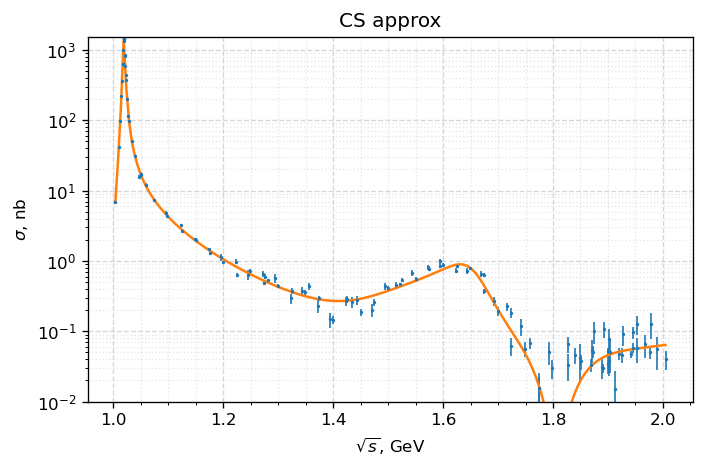

In [118]:
plt.errorbar(dfs.emeas, dfs.cs_born, yerr=dfs.cs_born_err, fmt='.', label=f'Measured cs', alpha=1, markersize=2, lw=1)
plt.plot(xx, yy)
pys.my_style(title='CS approx', xtitle='$\sqrt{s}$, GeV', ytitle='$\sigma$, nb',
            ylim=(1e-2, None))
plt.yscale('log')

In [122]:
df_fit = pd.DataFrame({'emeas': xx, 'cs_born': yy})

## Радпоправки

In [123]:
df_fit.head()

emeas      cs_born
0  1.004066     6.855869
1  1.009094    28.046279
2  1.014122   148.726144
3  1.019150  1409.010518
4  1.024178   277.801752

In [147]:
from pylib.radcors import RadCor
from pylib.regeff import RegEff

In [136]:
r = RadCor(df_fit.emeas*0.5e3, df_fit.cs_born)

In [139]:
df_regeff = pd.read_csv('images/reg_eff_19.csv', index_col=0)

In [163]:
ens, rads = [], []
for i, j in df_regeff.iterrows():
    rad, rad_err = r.F_Radcor(i, j[:4])/RegEff.sigFunc(0, *j[:4])
    ens.append(i)
    rads.append(rad)

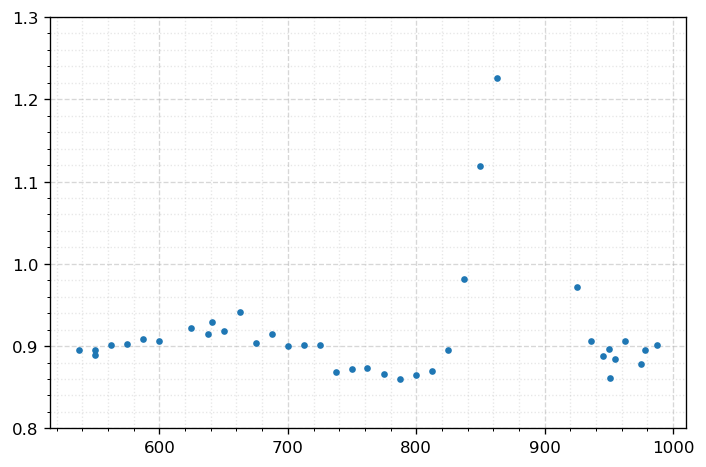

In [169]:
plt.errorbar(ens, rads, fmt='.')
pys.my_style(ylim=(0.8, 1.3))

In [55]:
t = uproot.open('/store17/petrov/data/kskl20/tr_ph/multi/tr_ph_kskl_950_79625.root')['tr_ph']

In [59]:
t.arrays?

Signature:
t.arrays(
    expressions=None,
    cut=None,
    filter_name=<function no_filter at 0x7fcc3adadb90>,
    filter_typename=<function no_filter at 0x7fcc3adadb90>,
    filter_branch=<function no_filter at 0x7fcc3adadb90>,
    aliases=None,
    language=<uproot.language.python.PythonLanguage object at 0x7fcc3ad9f290>,
    entry_start=None,
    entry_stop=None,
    decompression_executor=None,
    interpretation_executor=None,
    array_cache='inherit',
    library='ak',
    how=None,
)
Docstring:
Args:
    expressions (None, str, or list of str): Names of ``TBranches`` or
        aliases to convert to arrays or mathematical expressions of them.
        Uses the ``language`` to evaluate. If None, all ``TBranches``
        selected by the filters are included.
    cut (None or str): If not None, this expression filters all of the
        ``expressions``.
    filter_name (None, glob string, regex string in ``"/pattern/i"`` syntax, function of str → bool, or iterable of the above):

In [63]:
arrt, arrs = t.arrays(expressions=['trho', 'simtype'], library='pd')

In [74]:
arrt

trho
entry subentry          
0     0         0.003162
      1        -0.004339
1     0         0.010883
2     0        -0.029699
      1         0.024816
...                  ...
99998 0        -0.003227
      1         0.050302
      2        -0.038940
99999 0         0.006211
      1        -0.073825

[243870 rows x 1 columns]

In [86]:
arrt = arrt.reset_index().drop('subentry', axis=1).set_index('entry')

In [89]:
arrtkskl = arrt.loc[arrt.index & ((arrs == 130) | (arrs == 310)).groupby('entry').agg('max').query('simtype').index]
arrtnotkskl = arrt.loc[arrt.index & ((arrs == 130) | (arrs == 310)).groupby('entry').agg('max').query('simtype==False').index]

MultiIndex([], names=['entry', 'subentry'])

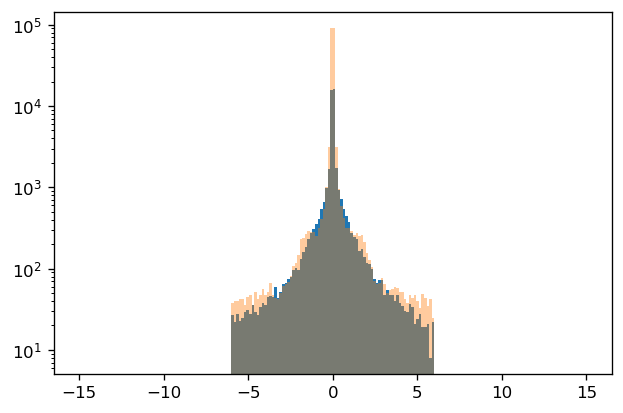

In [92]:
plt.hist( arrtkskl.trho, bins=200, range=(-15, 15) );
plt.hist( arrtnotkskl.trho, bins=200, range=(-15, 15), alpha=0.4 );
plt.yscale('log')